In [1]:
# get data from kaggle's fire and smoke data set 
import os
os.listdir(os.getcwd())
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
google-cloud-aiplatform 0.6.0a1 requires google-cloud-storage<2.0.0dev,>=1.26.0, but you have google-cloud-storage 2.1.0 which is incompatible.
gcsfs 2022.2.0 requires fsspec==2022.02.0, but you have fsspec 2022.3.0 which is incompatible.
en-core-web-sm 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.4.2 which is incompatible.
en-core-web-lg 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.4.2 which is incompatible.
apache-beam 2.37.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.37.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.4 which is incompatible.
apache-beam 2.37.0 requires pyarrow<7.0.0,>=0.15.1, but you have pyarrow 7.0.0 which is incompatibl

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('man', max_images=1)
urls[0]

Searching for 'man'


'https://pixy.org/src/476/4763222.jpg'

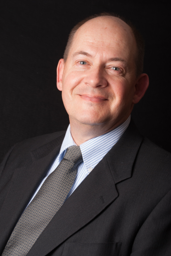

In [4]:
from fastdownload import download_url
dest = 'man.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [5]:
%config Completer.use_jedi = False

import os

SRC_IMAGES_DIR = '../input/d/ashutosh69/fire-and-smoke-dataset/data/data/img_data/train/'
    
def get_images(path):
    image_path = SRC_IMAGES_DIR + path
    return [os.path.abspath(os.path.join(image_path, p)) for p in os.listdir(image_path)]


fire_images = get_images('fire')
smoke_images = get_images('smoke')
# print(fire_images)

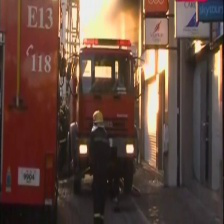

In [6]:
from fastai.vision.all import *
from fastcore.all import *
import random

im = Image.open(random.choice(fire_images))
im.to_thumb(256,256)

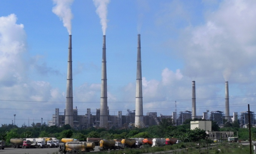

In [7]:
im = Image.open(random.choice(smoke_images))
im.to_thumb(256,256)

In [8]:
!rm -rf fire_or_not

path = Path('fire_or_not')
images = 'fire', 'smoke'

for o in images:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    resize_images(SRC_IMAGES_DIR + o, max_size=400, dest=path/o)

In [9]:
searches = 'man','background'
from time import sleep
location = (path / "other")
    
for o in searches:
    location.mkdir(exist_ok=True, parents=True)
    download_images(location, urls=search_images(f'{o} photo'))
    sleep(2)  # Pause between searches to avoid over-loading server
    download_images(location, urls=search_images(f'{o} sun photo'))
    sleep(2)
    download_images(location, urls=search_images(f'{o} shade photo'))
    sleep(2)
    resize_images(location, max_size=400, dest=location)

Searching for 'man photo'
Searching for 'man sun photo'
Searching for 'man shade photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'background photo'
Searching for 'background sun photo'
Searching for 'background shade photo'


In [10]:
# print(path)
# os.listdir('./fire_or_not/smoke')

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

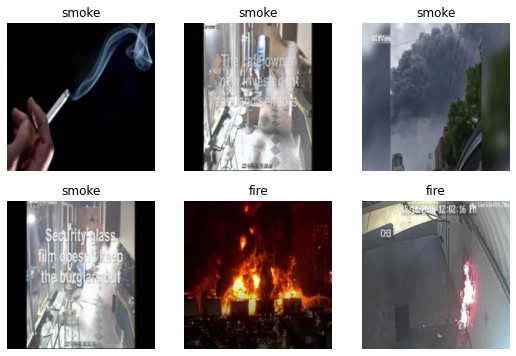

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.172363,0.478182,0.127358,01:41


epoch,train_loss,valid_loss,error_rate,time
0,0.407203,0.405655,0.094340,02:31
1,0.268850,0.383864,0.080189,02:31
2,0.171477,0.399853,0.080189,02:31
3,0.115982,0.406073,0.084906,01:41


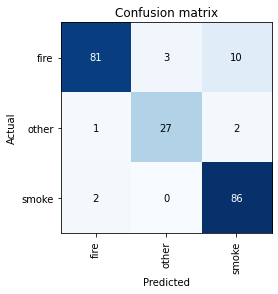

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
learn.export("./fso_model.pkl")
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('fso_model.pkl')]

In [15]:
model_inf = load_learner(path/'fso_model.pkl')
model_inf.predict(random.choice(get_image_files(Path("fire_or_not/fire"))))

('fire', tensor(0), tensor([9.9996e-01, 4.4566e-05, 6.6040e-09]))

In [16]:
chosen_image = random.choice(get_image_files(Path("fire_or_not/smoke")))

In [17]:
is_fire_accident,_,probs = learn.predict(chosen_image)
print(f"This is a: {is_fire_accident}.")
print(f"Probability it's a fire: {probs[0]:.4f}")

This is a: smoke.
Probability it's a fire: 0.0001


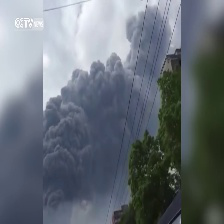

In [18]:
im=Image.open(chosen_image)
im.to_thumb(256,256)